# Inflation Forecasting
> Description: Islamic Republic of Iran inflation forecasting with time series analysis
>
> Authors: Fatemeh Sadat Mousavi, Mahta Fetrat
>
> Affiliation: Students of Sharif University of Technology
>
> Date: Summer 1401

# **Inflation Analysis (Using the CPI factors)**

Load the cpi_factors dataset. This dataset contains the values for CPI and its factors from 01/1390 to 04/1401.

In [ ]:
# !pip install gdown
# annual CPI + CPI factors
!gdown --id 1ah7rQkY8vlXVUrhSduaFjD8P7X4pTuBy

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ah7rQkY8vlXVUrhSduaFjD8P7X4pTuBy
To: /content/cpi_factors .csv
100% 10.2k/10.2k [00:00<00:00, 33.2MB/s]



**Prediction steps:**

*   Data cleansing
*   Data Visualisation
*   Selection and application of Model
*   Hyper Parameter Tuning and selecting best model
*   Prediction and assessment


First import some useful libraries for loading and working with data.

Load the dataset and check a sample of it.

In [ ]:
# import useful libraries for working with data
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import read_csv

In [ ]:
# read the dataset. It was already uploaded on the google drive
data = read_csv('/content/cpi_factors .csv', sep=r'\s*,\s*', on_bad_lines='skip')

# check a sample of size 5 of the dataset
data.sample(5)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,date,food and beverages,apparel,housing,furniture,medical care,transportation,communication,recreation,education,hotel and restaurant,other goods and services,CPI
77,6/1/1396,109.5,109.6,107.5,118.5,120.6,105.1,107.7,109.1,115.4,105.6,105.2,107.0
5,6/1/1390,36.0,36.4,41.0,39.3,41.2,29.0,38.1,40.2,21.9,44.3,39.1,42.6
65,6/1/1395,100.0,100.0,99.9,102.7,102.9,101.2,99.7,99.8,92.6,104.3,99.9,99.8
46,11/1/1393,88.6,88.6,88.3,88.7,89.2,86.1,90.9,92.8,84.9,87.5,90.2,88.2
30,7/1/1392,78.8,78.6,74.0,82.8,85.1,70.9,78.4,87.9,72.4,77.9,77.8,74.8


In [ ]:
# check the number of features and records
number_of_records= data.shape[0]
number_of_features= data.shape[1]

print('number of records:', number_of_records)
print('number of features:', number_of_features)

number of records: 136
number of features: 13


**Data Preprocessing and Visualization:**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      136 non-null    object 
 1   food and beverages        136 non-null    float64
 2   apparel                   136 non-null    float64
 3   housing                   136 non-null    float64
 4   furniture                 136 non-null    float64
 5   medical care              136 non-null    float64
 6   transportation            136 non-null    float64
 7   communication             136 non-null    float64
 8   recreation                136 non-null    float64
 9   education                 136 non-null    float64
 10  hotel and restaurant      136 non-null    float64
 11  other goods and services  136 non-null    float64
 12  CPI                       136 non-null    float64
dtypes: float64(12), object(1)
memory usage: 13.9+ KB


We can see thst there is no missing value in the dataset. The only non-numeric column is date. As the time steps in this column are equal (monthly seperated), we simpley drop it.

In [ ]:
# view just the non-numeric features
categorical_data = data.select_dtypes(exclude=['int', 'float'])
categorical_data.head()

,date
0,1/1/1390
1,2/1/1390
2,3/1/1390
3,4/1/1390
4,5/1/1390


In [ ]:
# check the number of non-numeric features
print('number of non-numeric features:', categorical_data.shape[1])

number of non-numeric features: 1


In [ ]:
# drop the extra columns
data.drop(['date'], axis=1, inplace=True)

In [ ]:
# describe statistical parameters for each column
data.describe()

,food and beverages,apparel,housing,furniture,medical care,transportation,communication,recreation,education,hotel and restaurant,other goods and services,CPI
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,170.255147,169.188235,148.702206,176.874265,177.130882,176.007353,170.261765,174.290441,189.662500,162.673529,168.655147,144.647794
std,152.530180,151.388145,124.012725,151.528169,149.461400,166.071372,161.069893,216.460467,188.795462,146.099875,142.682194,105.816052
min,32.800000,33.000000,34.100000,37.300000,39.400000,26.500000,34.000000,33.300000,20.100000,38.300000,37.100000,38.400000
25%,79.675000,79.475000,74.375000,83.875000,85.175000,74.500000,80.725000,88.900000,75.725000,79.575000,81.825000,77.175000
50%,100.750000,100.750000,101.400000,103.000000,103.250000,101.200000,100.550000,101.100000,106.350000,103.150000,100.700000,101.000000
75%,219.375000,217.725000,172.625000,253.375000,255.325000,245.100000,202.375000,189.450000,267.075000,198.900000,249.025000,182.500000
max,778.500000,784.100000,667.000000,734.200000,744.400000,666.500000,911.700000,1666.500000,818.100000,741.300000,658.800000,504.300000


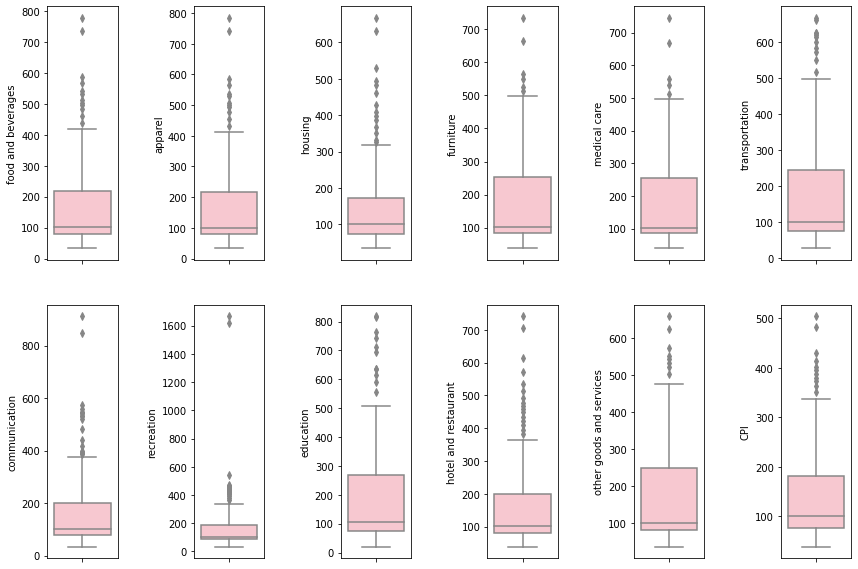

In [ ]:
# draw the boxplot of each feature
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols= 6, nrows= 2, figsize=(12, 8))
axs = axs.flatten()
index=0
types= data.dtypes
for k,v in data.items():
    if types[k]!= object:
        sns.boxplot(y= k, data= data, ax=axs[index],color='pink')
        index += 1
plt.tight_layout(pad=1, w_pad=3, h_pad=4)

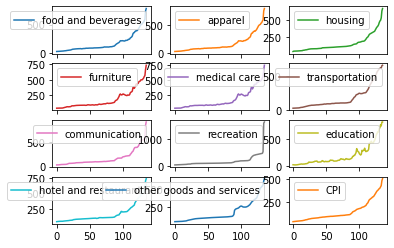

In [ ]:
# draw the plot of each feature
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

data.plot(subplots=True,layout=(4,3))
plt.show()

In [ ]:
cpi= data['CPI']

In [ ]:
# implement the ADF test to check if the series is stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(cpi)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 4.188614491988523
p-value: 1.0


In [ ]:
# try to make the series stationary by differencing
# 1st diff
result = adfuller(cpi.diff().dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 1.7915686042769865
p-value: 0.9983321473114258


In [ ]:
# 2nd diff
result = adfuller(cpi.diff().diff().dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.0319118437789316
p-value: 0.2727584792911474


In [ ]:
# 3rd diff
result = adfuller(cpi.diff().diff().diff().dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -4.926819627347781
p-value: 3.091601088921069e-05


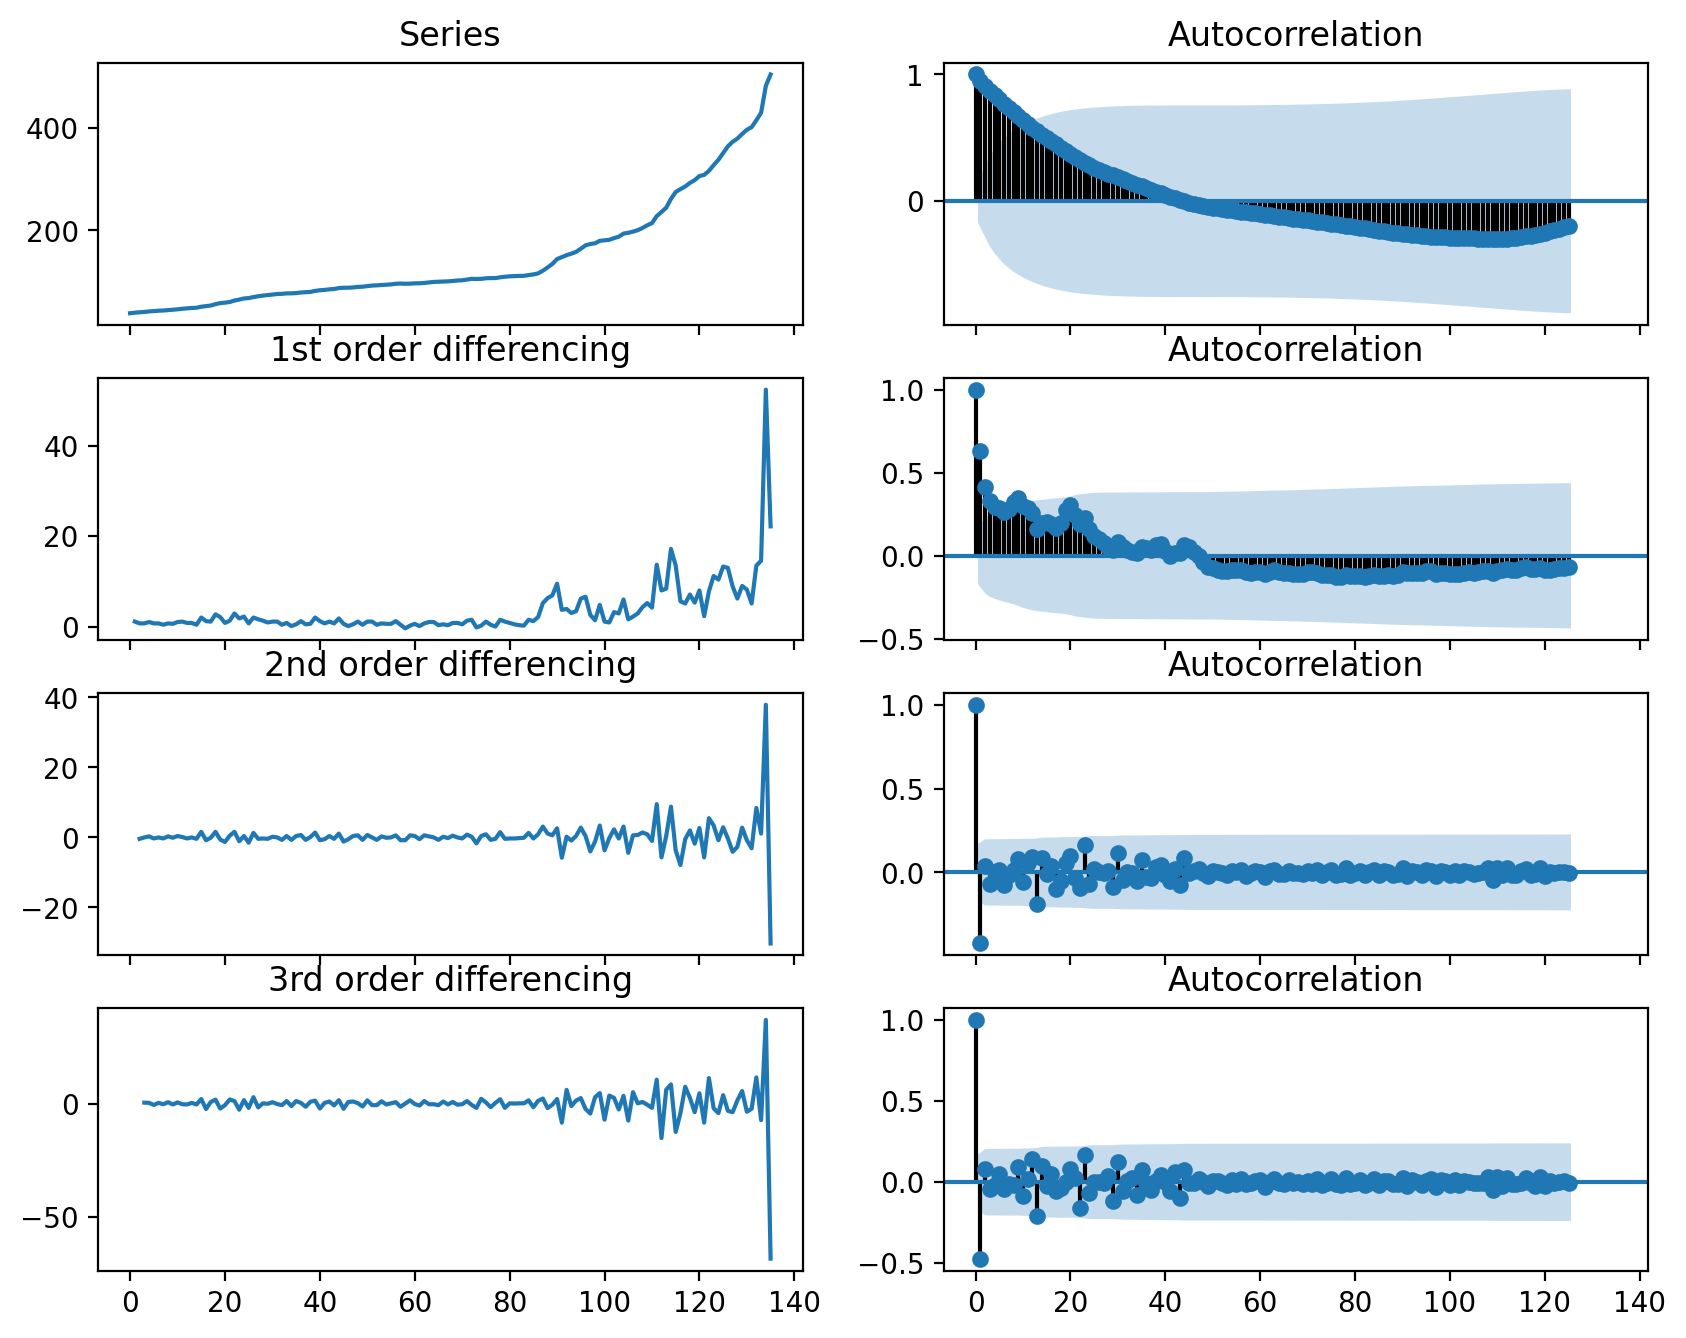

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':200})

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(cpi); axes[0, 0].set_title('Series')
plot_acf(cpi, ax=axes[0, 1],lags=125)

# 1st Differencing
axes[1, 0].plot(cpi.diff()); axes[1, 0].set_title('1st order differencing')
plot_acf(cpi.diff().dropna(), ax=axes[1, 1],lags=125)

# 2nd Differencing
axes[2, 0].plot(cpi.diff().diff()); axes[2, 0].set_title('2nd order differencing')
plot_acf(cpi.diff().diff().dropna(), ax=axes[2, 1],lags=125)

# 3rd Differencing
axes[3, 0].plot(cpi.diff().diff().diff()); axes[3, 0].set_title('3rd order differencing')
plot_acf(cpi.diff().diff().diff().dropna(), ax=axes[3, 1],lags=125)

plt.show()

In [ ]:
# d= 3

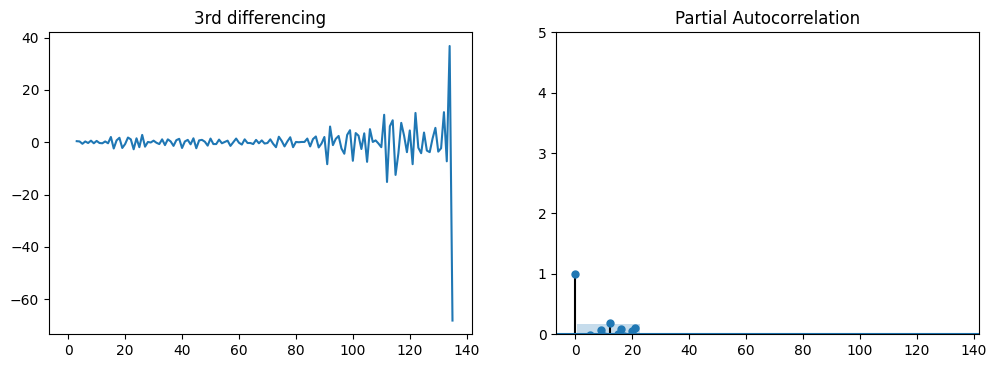

In [ ]:
# PACF plot of 3rd differenced series
plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':100})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(cpi.diff().diff().diff()); axes[0].set_title('3rd differencing')
axes[1].set(ylim=(0,5))
plot_pacf(cpi.diff().diff().diff().dropna(), ax=axes[1])

plt.show()

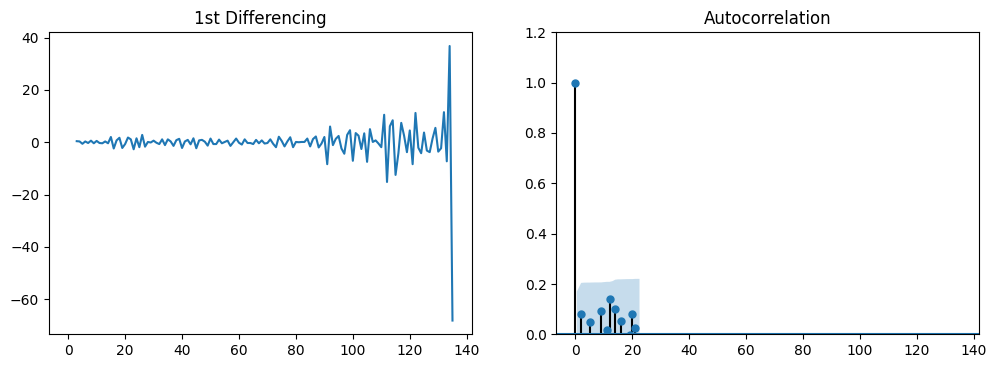

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(cpi.diff().diff().diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(cpi.diff().diff().diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
# p= 1
# try p= 1 and d= 3 (maybe over diff (needs to increase p)) and q= 1
# and p= 1 and d= 2 (maybe under diff (needs to increase q)) and q= 1

In [ ]:
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(cpi, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                  136
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -384.442
Date:                Thu, 25 Aug 2022   AIC                            776.884
Time:                        20:41:22   BIC                            788.505
Sample:                             0   HQIC                           781.606
                                - 136                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9769      0.051     19.152      0.000       0.877       1.077
ma.L1         -0.5455      0.073     -7.468      0.000      -0.689      -0.402
ma.L2          0.2178      0.228      0.955      0.3

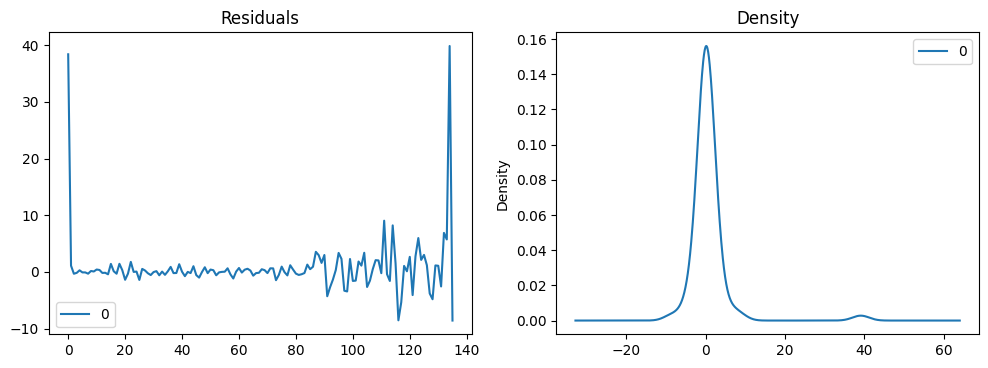

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

AttributeError: ignored

In [ ]:
from statsmodels.tsa.stattools import acf

# Train and Test split
train = cpi[:130]
test = cpi[130:]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(2,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
# Forecast
fc, se, conf = model_fit.forecast(6, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc_series, test.values)

In [ ]:
data.columns

In [ ]:
model_fit.plot_diagnostics()
plt.show()

# **Forcast the factors of CPI**

**Food and beverages**

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [ ]:
time= list(range(np.shape(data)[0]))
series= data['CPI']

In [ ]:
plot_series(time, series, xlabel='Month', ylabel='Monthly CPI')

In [ ]:
# Define the split time
split_time = 120

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
# Parameters
window_size = 10
batch_size = 16
shuffle_buffer_size = 10

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=8, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
#   tf.keras.layers.LSTM(64, return_sequences=True),
#   tf.keras.layers.LSTM(64),
#   tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
model.summary()

In [ ]:
# Get initial weights
init_weights = model.get_weights()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [ ]:
# Set the learning rate
learning_rate = 1e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
history = model.fit(train_set,epochs=10)

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
results

In [ ]:
# One thing we can do for preparing data is to scale it
# this is useful for optimization algorithms used in machine learning algorithms, algorithms like regression
# which weight fratures, nn and algorithms like KNN which use distance measures
# one way is to normalize the values:

# # we only consider the columns containing numerical types:
# # calculate for x in arr: x= ((x- min(arr))/(max(arr) - min(arr))) which scales values of arr in ranage [0,1]
# normalized_data=(data-data.min())/(data.max()-data.min())
# print(normalized_data.head(5))

# another method is using MinMaxScaler class in sickit-learn package
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# fit the scaler on data
# apply transform
X[X.columns] = scaler.fit_transform(X)
X.head()

In [ ]:
# view the heatmap of correlation of differnet columns
plt.figure(figsize=(20, 10))
# see pairwise correlation of numerical features
sns.heatmap(data.corr(),  annot=True);

In [ ]:
print(y)

In [ ]:
from sklearn.model_selection import train_test_split
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Train different models to predict the response variable and evaluate each of them.

In [ ]:
# linear regression
# calculate the standard error of each coefficient, t-satittc. We can also see the overall
# F-statistic of the model, the adjusted R-squared value, AIC, and so on.

import statsmodels.api as sm

# add constant to the predictor matrix
X_matrix_train = sm.add_constant(X_train)

# fit linear regression model
model = sm.OLS(y_train, X_matrix_train).fit()

# view model summary
print(model.summary())

Based on the linear regression results:


- increase in income causes less depression

- teachers and employees are two groups which are probably less vulnerable to depression.

- house wives have a positive coefficient but there is a high p-value and small t-statistic. so we can't approve the result of its effect on depression.

- marriage has a strong effect on decreasing the rate of dejection. also widows or divorced people are more رulnerable to depression.

- as we obtained large p-value for level of education, we can't conclude that higher education causes increase in depression level.

- the more poeple have strong faith the less they are vulnerable to depression

- the more people travel the less they are vulnerable to depression

- the more people do exercises the less they are Vulnerable to depression. These results are more reliable than others as we can observe a high t-statistic and low p-value

- people with more children are less vulnerable to depression

In [ ]:
# train a multiple linear regression model to predict depression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# create a linear regressor
linear_regressor = LinearRegression()

# fit the model on the data
linear_fit= linear_regressor.fit(X_train,y_train)
prediction =  linear_regressor.predict(X_test)

# evaluation of mse of the linear regression model
test_mse= mean_squared_error(y_test, prediction)
print("The value of mse using multiple linear regression:", test_mse, end='\n\n')


print(f"intercept: {linear_regressor.intercept_}",end='\n\n')
print(f"coefficients: {linear_regressor.coef_}")


In [ ]:
%pip install mlxtend --upgrade

In [ ]:
# estimate bias and variance
from mlxtend.evaluate import bias_variance_decomp

mse, bias, var = bias_variance_decomp(linear_regressor, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), loss='mse', num_rounds=200, random_seed=1)
# the results:
print('mse: %.3f' % mse)
print('bias: %.3f' % bias)
print('variance: %.3f' % var)

In [ ]:
# print the coeffiecient for each feature
linear_regression_coeffs= linear_regressor.coef_
print("the coeffiecient for each feature:")
print()
X_columns= X.columns
for i in range(len(X.columns)):
  print ('    ', X_columns[i] , ":", linear_regression_coeffs[i] )


Based on these multiple linear regression coefficients, we can see the relation between each predictor and the result for depression level.
forexmple We can see that probably more exercise plays a role in reducing depression because the coefficient obtained for sport is negative. The same applies to faith, marriage and the number of children.

On the contrary, it seems that increasing age and divorce or the death of a spouse are effective in increasing the probability of depression

**Evaluation of regression model**

---



**Mean absolute error:** This is the average of absolute errors of all the data points in the given dataset.


**Mean squared error:** This is the average of the squares of the errors of all the data points in the given dataset.


**Median absolute error:** This is the median of all the errors in the given dataset. The main advantage of this metric is that it's robust to outliers. A single bad point in the test dataset wouldn't skew the entire error metric, as opposed to a mean error metric.


**Explained variance score:** This score measures how well our model can account for the variation in our dataset. A score of 1.0 indicates that our model is perfect.


**R2 score:** This score refers to the coefficient of determination. This tells us how well the unknown samples will be predicted by our model. The best possible score is 1.0.

In [ ]:
# evaluation of multiple linear regression model
import sklearn.metrics as sm

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, prediction), 3))
print("Mean squared error =", round(sm.mean_squared_error(y_test, prediction), 3))
print("Median absolute error =", round(sm.median_absolute_error(y_test, prediction), 3))
print("Explain variance score =", round(sm.explained_variance_score(y_test, prediction), 3))
print("R2 score =", round(sm.r2_score(y_test, prediction), 3))

Find the outliers and high leverage points

In [ ]:
# # remove the high residual and high leverage points
# import seaborn as sb
# import matplotlib.pyplot as plt
# from statsmodels.regression.linear_model import OLS
# from statsmodels.stats.outliers_influence import OLSInfluence as olsi

# model = OLS(y_train, X_train)
# result = model.fit()

# studentized_residuals = olsi(result).resid_studentized

# # based on a simple rule we consider the datapoints with studentized residual absolute value
# # greater than 3 as outliers

# numpy_studentized_residuals= np.array(studentized_residuals)
# outliers= np.where(abs(numpy_studentized_residuals)> 3)
# print("The indices of the outliers:", outliers[0], end= '\n\n')

# #  we consider this value: (p+1)/n
# # where p is the number of the features and n is the number of datapoints
# # a point is considered as a high leverage point if its leverage is much grater than this value

# val= (np.shape(X_train)[1]+1)/np.shape(X_train)[0]
# print("(p+1)/n is:", val, end='\n\n')


# # X_train_eddited= X_train.drop(outliers[0])
# # y_train_eddited= y_train.drop(outliers[0])

# leverage_pts = olsi(result).hat_matrix_diag    # find the array of leverage values
# high_leverage_pts= np.where(leverage_pts>val*4)
# print("Number of the high leverage points:",np.shape(high_leverage_pts)[1])
# print("Leverage points:", high_leverage_pts[0])
# print(X_train_eddited.shape)
# print(X_train_eddited['education'][81])
# X_train_eddited=  X_train_eddited.drop(81,0)
# y_train_eddited=  y_train_eddited.drop(high_leverage_pts[0],0)
# print("The number of datapoints after removing high residual and high leverage points:", len(X_train_eddited), end= '\n\n')


# sb.residplot(x = studentized_residuals, y = leverage_pts, color = 'purple')
# plt.xlabel("studentized residuals")
# plt.ylabel("leverage")
# plt.show()


In [ ]:
# # now we gonna train our model again on the eddited dataset and see the effect of removing high residual and high leverage points
# # train a multiple linear regression model to predict depression. in this example no special differece was obtained (notice the absoulte values
# # were not too much greater than 3 (actually there were close to 3))
# import statsmodels.api as sm

# # add constant to the predictor matrix
# X_matrix_train = sm.add_constant(X_train_eddited)

# # fit linear regression model
# model = sm.OLS(y_train_eddited, X_matrix_train).fit()

# # view model summary
# print(model.summary())

In [ ]:
# implement random forest
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
random_forest = RandomForestRegressor(n_estimators = 100, random_state = 42)

# train the model
random_forest.fit(X_train, y_train);

# prediction of the test data
prediction = random_forest.predict(X_test)
p2= random_forest.predict(X)
# calculate the absolute errors
errors = abs(prediction - y_test)
mae= round(np.mean(errors), 2)

# the mean absolute error (mae)
print('MAE:',mae)

# calculate mean absolute percentage error
mape =  100* (errors / y_test)

# calculate the accuracy of random forest model
accuracy = 100 - np.mean(mape)

print('accuracy of the random forest model:', round(accuracy, 2), '%.')

# MAE: 0.1
# accuracy obtained: 95.53 %.

In [ ]:
plt.plot(p2)
plt.plot(y)
plt.show()
